In [1]:
import numpy as np
import pandas as pd
import string
import nltk
import time

from matplotlib import pyplot as plt

from scipy import sparse

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import SnowballStemmer

from sklearn.cluster import KMeans, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score, calinski_harabaz_score

rng = np.random

In [2]:
df = pd.read_csv('../data/news_headlines.csv')

print('Total rows: %d\n10 random rows:' % (len(df)))
df.iloc[rng.choice(np.arange(len(df)), 10), :]

Total rows: 1000001
10 random rows:


,publish_date,headline_text
315577,20070911,too many meals not enough wheels expert forecasts
522859,20100526,no movement on roundtable chairman bartlett
343566,20080208,aus lead after davis cup first rubber
645582,20121213,halter honey
980078,20171022,catalan independence supporters react to artic...
747691,20131102,portugese police focus on dead hotel worker in...
993638,20170719,elijah doughty accused family safety concerns
12830,20030822,qld gains new federal electorate
413147,20091012,storm founder knew company was in trouble
568805,20110119,injured kallis named in sa world cup squad


In [3]:
stemmer = SnowballStemmer('english')

for headline in df['headline_text']:
    stemmed_words = [stemmer.stem(w) for w in word_tokenize(headline)]
    headline = ' '.join(stemmed_words)


In [4]:
# break dataset by year
print('min date = %d\nmax date = %d' % (np.min(df['publish_date']), np.max(df['publish_date'])))

df_year = {}

for y in np.arange(2003, 2018):
    subdf = df[(df['publish_date'] >= y * 1e4) & (df['publish_date'] < (y + 1) * 1e4)]
    df_year[y] = subdf
    
    print('year %d length = %d' % (y, len(subdf)))

df_year.keys()

min date = 20030219
max date = 20171231
year 2003 length = 59343
year 2004 length = 65975
year 2005 length = 66320
year 2006 length = 61568
year 2007 length = 69431
year 2008 length = 71591
year 2009 length = 68867
year 2010 length = 67715
year 2011 length = 69919
year 2012 length = 78547
year 2013 length = 81016
year 2014 length = 73361
year 2015 length = 70004
year 2016 length = 52162
year 2017 length = 44182


dict_keys([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

total unique words in entire corpus (takes a bit to process): there are **80570** unique words without stemming and **the same** when using stemming. WAT

``` Python
len(set(word_tokenize(' '.join(df['headline_text']))))
```

In [5]:
# This one takes a little while
def sanitise_words(a):
    '''
    Receives a array of words and sanitises it,
    removing stop words, punctuation and numbers
    (if that is the case).
    '''
    en_stopwords = set(stopwords.words('english'))
    sanitised = []
    
    for w in a:
        # stopwords do not include punctuation
        # isalpha() is also excluding numbers
        # use and (w.isalpha() or w.isnumeric)
        if not w in en_stopwords and w.isalpha():
            sanitised.append(w)
    
    return sanitised


In [6]:
def word_histogram(df):
    '''
    Receives a pandas DataFrame as input (SHOULD RECEIVE AN ARRAY)
    that may be formed by either words or sentences and caculates
    a word histogram considering the whole of its corpus.
    '''
    words = np.array(df['headline_text'])
    words = ' '.join(words)
    words = word_tokenize(words)
    words = sanitise_words(words)
    word_hist = {}
    
    for w in words:
        word_hist[w] = (word_hist.get(w) or 0) + 1
        
    return word_hist


In [6]:
# just an example, don't need to run this cell
whist = word_histogram(df)

dfhist = pd.DataFrame.from_dict(whist, orient='index')
dfhist.columns = ['count']
dfhist = dfhist.sort_values('count', ascending=False)

The basics:
- Tokenise
- Remove stop words
- **Remove numbers?**
- Remove punctuation
- Remove prefixes and suffixes

Wonders:
- Can I use a synonym dictionary to identify equivalence between words? What about each word being synonym of 2 semantically different words? Any examples?


# Feature extraction

## TD-IDF
The code below is almost a copy-paste from [this sklearn example](http://scikit-learn.org/stable/auto_examples/text/document_clustering.html#sphx-glr-auto-examples-text-document-clustering-py)

In [7]:
counter = CountVectorizer()
tfidft = TfidfTransformer(smooth_idf=True)
tfidfv = TfidfVectorizer(stop_words='english')

In [8]:
data = df_year[2017]['headline_text']

In [9]:
term_matrix = counter.fit_transform(data)

In [15]:
tfidf_vecs = tfidfv.fit_transform(data)

tfidf_vecs.shape

(44182, 22527)

### Dimensionality reduction evaluation by PCA/SVD variance (BEFORE actual reduction)

In [16]:
n_comps = 2500
tsvd = TruncatedSVD(n_components=n_comps) # WARNING: this uses ALL THE RAM for ultra high values, and like 40-50% at 2500

t0 = time.time()
tsvd.fit(tfidf_vecs)

print('SVD finished in %.1fs' % (time.time() - t0))


SVD finished in 140.7s


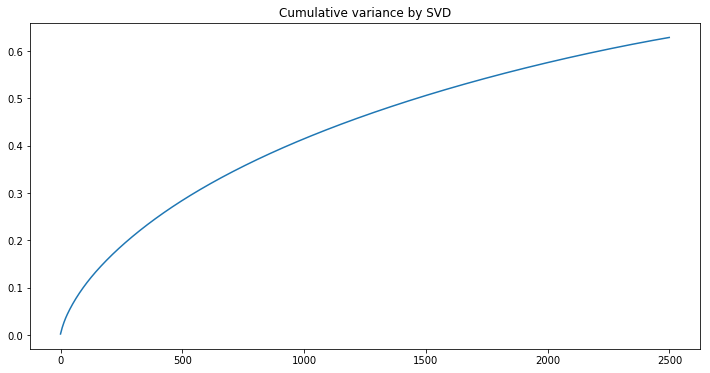

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(n_comps), np.cumsum(tsvd.explained_variance_))
plt.title('Cumulative variance by SVD')
plt.show()

In [19]:
np.sum(tsvd.explained_variance_), np.sum(trunc.explained_variance_)

(0.6288565816456811, 0.2065915282355343)

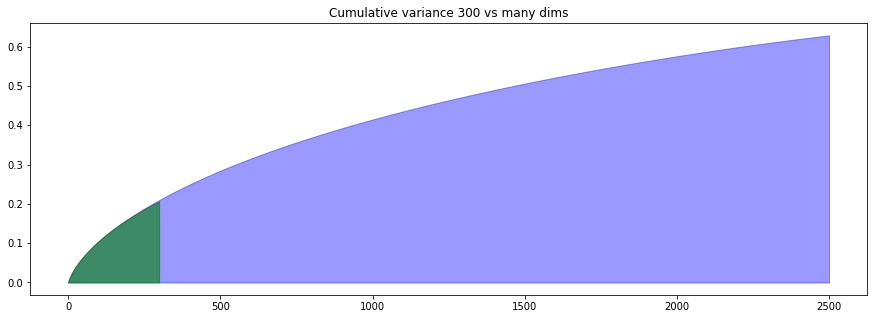

In [20]:
plt.figure(figsize=(15, 5))
plt.fill_between(np.arange(len(trunc.explained_variance_)), np.cumsum(trunc.explained_variance_), alpha=0.6, color='green', zorder=2)
plt.fill_between(np.arange(len(tsvd.explained_variance_)), np.cumsum(tsvd.explained_variance_), alpha=0.4, color='blue', zorder=1)
plt.title('Cumulative variance 300 vs many dims')
plt.show()

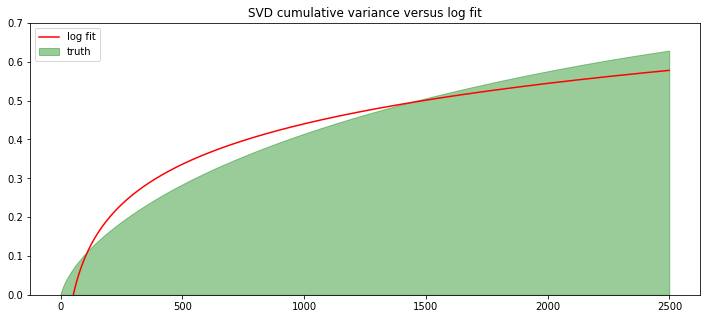

In [66]:
x = np.arange(len(tsvd.explained_variance_))
y_cdf = np.cumsum(tsvd.explained_variance_)

[c1, c2] = np.polyfit(np.log(1 + x), y_cdf, 1)

y_fit = c1 * np.log(1+x) + c2

plt.figure(figsize=(12,5))
plt.fill_between(x, y_cdf, color='green', alpha=0.4, label='truth')
plt.plot(x, y_fit, color='red', label='log fit')
plt.ylim(0, 0.7)
plt.title('SVD cumulative variance versus log fit')
plt.legend(loc='upper left')
plt.show()


The meaning of this plot: too little energy per dimension. This cumulative sucks. TD-IDF does not seem to be working well enough.

The other plot only says the cumulative energy has even worse behaviour than expected by a log fit.

### Dimensionality reduction (LSA) and normalisation

In [17]:
trunc = TruncatedSVD(n_components=300)
norm = Normalizer(norm='l2')
lsa_pipe = make_pipeline(trunc, norm)

t0 = time.time()
tfidf_vecs = lsa_pipe.fit_transform(tfidf_vecs)

print('Dimensionality reduction finished after %.1fs' % (time.time() - t0))


Dimensionality reduction finished after 9.5s


## Word2Vec by gensim lib
Tensorflow also has an implementation but it looks like it's supervised, and I don't want that.

In [ ]:
# TODO: word2vec feature extraction

# Clustering

## k-Means

### Grid search

In [76]:
k_values = np.arange(10, 61, 5)
km_scores_df = pd.DataFrame(columns=('k', 'inertia', 'silhouette', 'calinski_harabaz'))

for k in k_values:
    km = KMeans(n_clusters=k, n_jobs=4)
    t0 = time.time()
    
    km.fit(tfidf_vecs)
    
    print('k-Means trained with k = %d in %.1fs' % (k, time.time() - t0))
    
    km_scores_df.loc[len(km_scores_df)] = [k, km.inertia_,
        silhouette_score(tfidf_vecs, km.labels_, metric='euclidean', sample_size=200),
        calinski_harabaz_score(tfidf_vecs, km.labels_)]

print('done')


k-Means trained with k = 10 in 12.6s
k-Means trained with k = 15 in 16.2s
k-Means trained with k = 20 in 20.1s
k-Means trained with k = 25 in 22.9s
k-Means trained with k = 30 in 27.2s
k-Means trained with k = 35 in 31.4s
k-Means trained with k = 40 in 36.4s
k-Means trained with k = 45 in 35.0s
k-Means trained with k = 50 in 42.1s
k-Means trained with k = 55 in 43.9s
k-Means trained with k = 60 in 44.5s
done


### Scoring

In [77]:
km_scores_df

,k,inertia,silhouette,calinski_harabaz
0,10.0,40788.053746,0.033597,353.238513
1,15.0,39847.438772,0.021359,306.886076
2,20.0,38973.084201,0.044098,283.319072
3,25.0,38311.508930,0.021087,259.913217
4,30.0,37573.271592,0.015294,249.215633
5,35.0,36954.591057,0.039037,237.838553
6,40.0,36250.142942,0.010264,233.347041
7,45.0,35645.119762,0.031605,227.343461
8,50.0,35251.471374,0.015830,216.458895
9,55.0,34497.884687,0.056461,218.534812


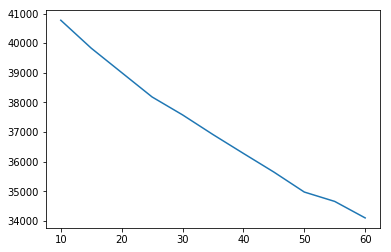

In [13]:
plt.plot(km_scores_df['k'], km_scores_df['inertia'])

## Meanshift

### Grid search

In [68]:
# Bandwidth estimation can be a serious bottleneck, so we are checking it first. Best time vs consistent value wins
quantiles = np.arange(0.1, 0.5, 0.1)
n_samples = np.array([100, 500, 1000, 2000, 3000, 4000, 5000])
bw_bench_df = pd.DataFrame(columns=('n_samples', 'quantile', 'bandwidth', 'elapsed_time'))
iteration = 1

for q in quantiles:
    for n in n_samples:
        t0 = time.time()
        bw = estimate_bandwidth(tfidf_vecs, quantile=q, n_samples=n, n_jobs=4)
        elapsed = time.time() - t0
        bw_bench_df.loc[len(bw_bench_df)] = [n, q, bw, elapsed]
        
        print('bandwidth calculation %d/%d benchmark pair (%.1f, %d) finished in %.1fs' % (iteration, len(quantiles) * len(n_samples), q, n, elapsed))
        
        iteration += 1

print('done')
bw_bench_df

bandwidth calculation 1/28 benchmark pair (0.1, 100) finished in 0.1s
bandwidth calculation 2/28 benchmark pair (0.1, 500) finished in 0.1s
bandwidth calculation 3/28 benchmark pair (0.1, 1000) finished in 0.2s
bandwidth calculation 4/28 benchmark pair (0.1, 2000) finished in 0.8s
bandwidth calculation 5/28 benchmark pair (0.1, 3000) finished in 1.9s
bandwidth calculation 6/28 benchmark pair (0.1, 4000) finished in 3.5s
bandwidth calculation 7/28 benchmark pair (0.1, 5000) finished in 4.7s
bandwidth calculation 8/28 benchmark pair (0.2, 100) finished in 0.1s
bandwidth calculation 9/28 benchmark pair (0.2, 500) finished in 0.1s
bandwidth calculation 10/28 benchmark pair (0.2, 1000) finished in 0.2s
bandwidth calculation 11/28 benchmark pair (0.2, 2000) finished in 0.8s
bandwidth calculation 12/28 benchmark pair (0.2, 3000) finished in 1.7s
bandwidth calculation 13/28 benchmark pair (0.2, 4000) finished in 3.3s
bandwidth calculation 14/28 benchmark pair (0.2, 5000) finished in 5.2s
bandw

,n_samples,quantile,bandwidth,elapsed_time
0,100.0,0.1,1.382410,0.111302
1,500.0,0.1,1.383969,0.112851
2,1000.0,0.1,1.383837,0.219506
3,2000.0,0.1,1.384616,0.832757
4,3000.0,0.1,1.384078,1.853399
5,4000.0,0.1,1.384050,3.469498
6,5000.0,0.1,1.384114,4.696407
7,100.0,0.2,1.397562,0.110983
8,500.0,0.2,1.397196,0.113445
9,1000.0,0.2,1.396986,0.216672


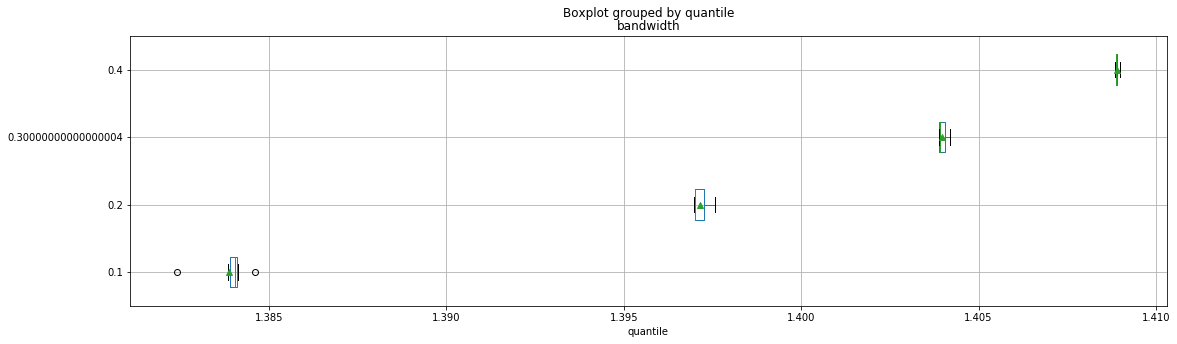

In [69]:
# Bandwidth benchmarking plot
bw_bench_df.boxplot(column='bandwidth', by='quantile', figsize=(18,5), showmeans=True, vert=False)

Conclusion from this plot: visually, the number of samples did not seem to change much the calculated bandwidth. Therefore, any value with the bigest sample size which performs well in time would suffice.

In [78]:
quantiles = np.arange(0.1, 0.6, 0.1) # must be in [0.1, 0.5]
ms_scores_df = pd.DataFrame(columns=('quantile', 'bandwidth', 'estimated_k', 'silhouette', 'calinski_harabaz'))
bw_factor = 0.4

for q in quantiles:
    bw = estimate_bandwidth(tfidf_vecs, quantile=q, n_samples=1000, n_jobs=4)
    ms = MeanShift(bandwidth=bw_factor*bw, bin_seeding=True, n_jobs=4)
    t0 = time.time()
    
    ms.fit(tfidf_vecs)
    
    print('Meanshift trained with q = %.1f, bw = %.3f in %.1fs' % (q, bw, time.time() - t0))
    
    ms_scores_df.loc[len(ms_scores_df)] = [q, bw_factor*bw, len(ms.cluster_centers_),
        silhouette_score(tfidf_vecs, ms.labels_, sample_size=200),
        calinski_harabaz_score(tfidf_vecs, ms.labels_)]

print('done')

Meanshift trained with q = 0.1, bw = 1.384 in 333.5s
Meanshift trained with q = 0.2, bw = 1.397 in 330.0s
Meanshift trained with q = 0.3, bw = 1.404 in 310.4s
Meanshift trained with q = 0.4, bw = 1.409 in 305.8s
Meanshift trained with q = 0.5, bw = 1.413 in 303.0s
done


### Scoring

The *Silhouette coefficient* goes from -1 (incorrect clustering) to +1 (high density clusters). Values near 0 indicate overlapping clusters. Favours convex clusters.

The *Calinski-Harabaz index* is higher the more dense and well separated the clusters are. Also favours convex clusters.

In [71]:
ms_scores_df

,quantile,bandwidth,estimated_k,silhouette,calinski_harabaz
0,0.1,0.691919,12.0,-0.001175,196.708329
1,0.2,0.698493,11.0,0.003952,216.123668
2,0.3,0.701943,11.0,0.010817,216.994872
3,0.4,0.704440,11.0,0.007533,205.872227
4,0.5,0.706492,11.0,0.013630,205.389891


## DBSCAN (WARN: THE GRID SEARCH IS TAKING THE WHOLE RAM!

## Grid search

In [ ]:
leaf_sizes = np.arange(10, 31, 10)
eps_vals = np.arange(0.1, 0.51, 0.1)
msamples = np.arange(10, 31, 10)
param_grid = np.array(np.meshgrid(leaf_sizes, eps_vals, msamples)).T.reshape(-1, 3)
db_score_df = pd.DataFrame(columns=('estimated_k', 'eps', 'min_samples', 'leaf_size', 'silhouette', 'calinski-harabaz'))

for l, e, s in param_grid:
    db = DBSCAN(eps=l, min_samples=s, metric='minkowski', p=2, algorithm='ball_tree', leaf_size=l, n_jobs=4)

    t0 = time.time()
    db.fit(tfidf_vecs)
    
    print('DBSCAN (leafs, eps, samples) = (%d, %.1f, %d) trained in %.1fs' % (l, e, s, time-time() - t0))
    
    # according to documentation:
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    
    db_score_df.loc[len(db_score_df)] = [n_clusters, e, s, l,
        silhouette_score(tfidf_vecs, db.labels_, sample_size=200),
        calinski_harabaz_score(tfidf_vecs, db.labels_)]

print('done')

array([1, 1, 0, 1])

## My clustering evaluation metric
"My" as in "I don't know if someone came up with this before, I just had this idea."

In [72]:
from sklearn.neighbors import KNeighborsClassifier

def knn_mismatch_score(X, labels, lnorm=2, weights='uniform'):
    '''
    Receives a data matrix X and (supposedly) predicted labels that cluster the data in X.
    
    It then uses a k-NN algorithm to re-label X and calculates the score as the number of mismatches
    between these labels and those given as parameter.
    '''
    unique_labels = np.unique(labels)
    knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', weights=weights, n_jobs=4, p=lnorm)
    
    knn.fit(X, labels)
    
    pred_labels = knn.predict(X)
    
    score = np.sum(np.equal(pred_labels, labels).astype(int)) / len(labels)
    
    return score


In [73]:
# a 5-minute test on predicted labels by a km and ms using UNIFORM weights
t0 = time.time()

print(knn_mismatch_score(tfidf_vecs, km.labels_, weights='uniform'))
print('knn mismatch score on km finished in %.1fs' % (time.time() - t0))

t0 = time.time()

print(knn_mismatch_score(tfidf_vecs, ms.labels_, weights='uniform'))
print('knn mismatch score on ms finished in %.1fs' % (time.time() - t0))

0.8958852021185097
knn mismatch score on km finished in 333.4s
0.8981259336381332
knn mismatch score on ms finished in 336.5s


In [74]:
# a 5-minute test on predicted labels by a km and ms using INVERSE DISTANCE weights
t0 = time.time()

print(knn_mismatch_score(tfidf_vecs, km.labels_, weights='distance'))
print('knn mismatch score on km finished in %.1fs' % (time.time() - t0))

t0 = time.time()

print(knn_mismatch_score(tfidf_vecs, ms.labels_, weights='distance'))
print('knn mismatch score on ms finished in %.1fs' % (time.time() - t0))

1.0
knn mismatch score on km finished in 332.5s
1.0
knn mismatch score on ms finished in 341.8s
